In [58]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

globalcount = 1
chess_board_size_x = 9
chess_board_size_y = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chess_board_size_y * chess_board_size_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_board_size_x, 0:chess_board_size_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_board_size_x,chess_board_size_y), None)

    # If found, add object points, image points
    if ret == True:
        #print ("Found corners")
        objpoints.append(objp)
        imgpoints.append(corners)
        

print ("Found object points:", len(objpoints), " & corners: ", len(imgpoints))

Found object points: 17  & corners:  17


In [59]:
# modularing code
def undistort_lens(img, objp, imgp):
    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist 
    

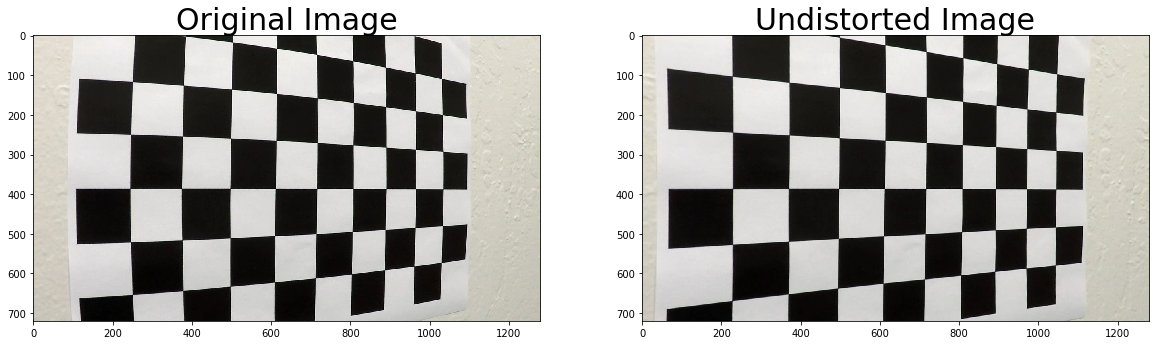

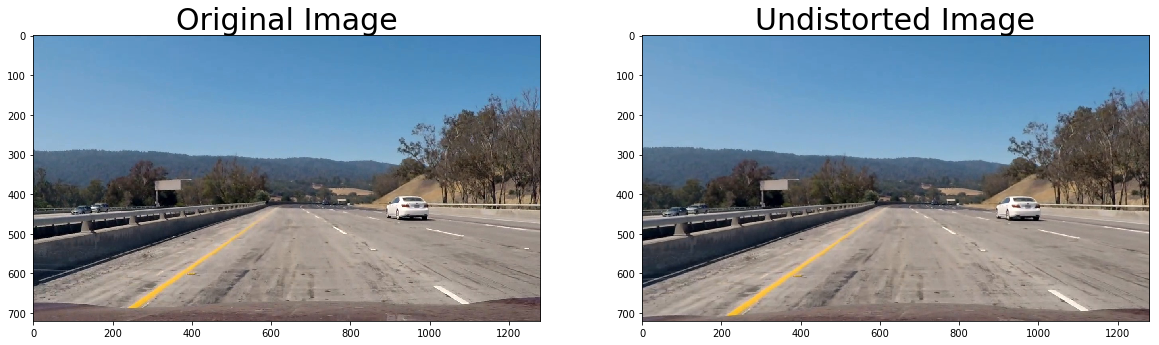

In [60]:
%matplotlib inline

# Test undistortion on an image
cal_img = mpimg.imread('camera_cal/calibration5.jpg')


cal_dst, cal_mtx, cal_dist = undistort_lens(cal_img, objpoints, imgpoints)
#----test with real image

img = mpimg.imread('test_images/orig3087.jpg')


dst, mtx, dist = undistort_lens(img, objpoints, imgpoints)

cv2.imwrite('output_images/test_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
# save the calibration so that we don't keep running the same. assuming lens is the same
pickle.dump( dist_pickle, open( "camera_cal/adv_lane_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cal_dst)
ax2.set_title('Undistorted Image', fontsize=30)

#--
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(img)
ax3.set_title('Original Image', fontsize=30)
ax4.imshow(dst)
ax4.set_title('Undistorted Image', fontsize=30)

In [61]:
def save_image(img, file):
 
    
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file, bgr_img)

In [76]:
def get_src_dest_warp_points(image):
    
    """
    corners = np.float32([[230, 690], [585, 450], [700, 455], [1060, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    """
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32(
        [[580, 460],
         [200, 720],
         [706, 460], 
         [1140, 720]])
    
    # Four Destination Points
    dst = np.float32(
        [[200, 100],
         [200, 720],
         [1040, 100], 
         [1040, 720]]) 
    
    #src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    #dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    
    """ this piece wasnt working too well. Used picture editor to manually come up with corners
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    """
    
    #print (src)
    #print (dst)
    return src, dst




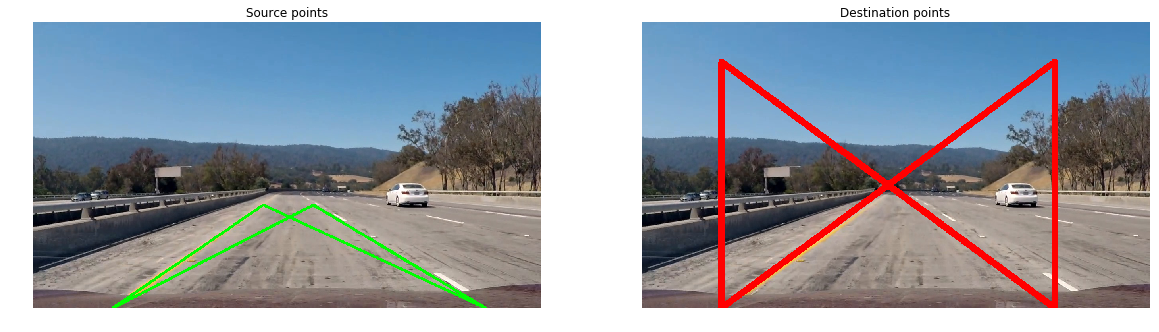

In [77]:
image = cv2.imread("test_images/orig3087.jpg")
src, dst = get_src_dest_warp_points(image)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 0), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points")
plt.axis("off")
save_image(points_image_src, "output_images/source_points.jpg")

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 0, 0), thickness=15)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points")
plt.axis("off")
save_image(points_image_dst, "output_images/destination_points.jpg");

In [78]:
def warp_image(img, src, dst, image_size):

    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

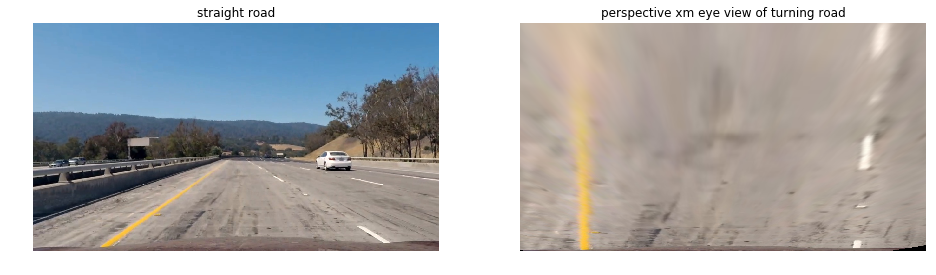

In [79]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/orig3087.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image, mtx, dist = undistort_lens(image, objpoints, imgpoints)
src, dst = get_src_dest_warp_points(image)
warped, _, _ = warp_image(image, src, dst, (image.shape[1], image.shape[0]))
save_image(warped, "output_images/warped_test_straight.jpg")

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("straight road");
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("perspective xm eye view of turning road")
plt.axis("off");

In [80]:
def thresholded_binary(undistorted_img):
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    #plt.imshow(sxbinary, cmap='gray')
    
    # Threshold color channel. From trial and error
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary



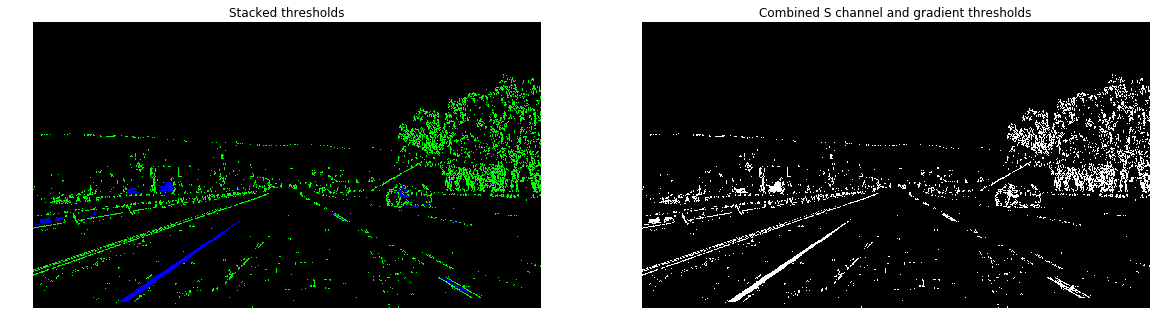

In [81]:
img = cv2.imread("test_images/orig3087.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img, mtx, dist = undistort_lens(img, objpoints, imgpoints)
color_binary, combined_binary = thresholded_binary(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)
ax1.axis("off");

# save as file
binary = 255 * color_binary.astype("uint8")
binary = cv2.cvtColor(binary, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/color_binary.jpg", binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")
ax2.axis("off");

# save as file
binary = 255 * combined_binary.astype("uint8")
cv2.imwrite("output_images/combined_binary.jpg", binary);

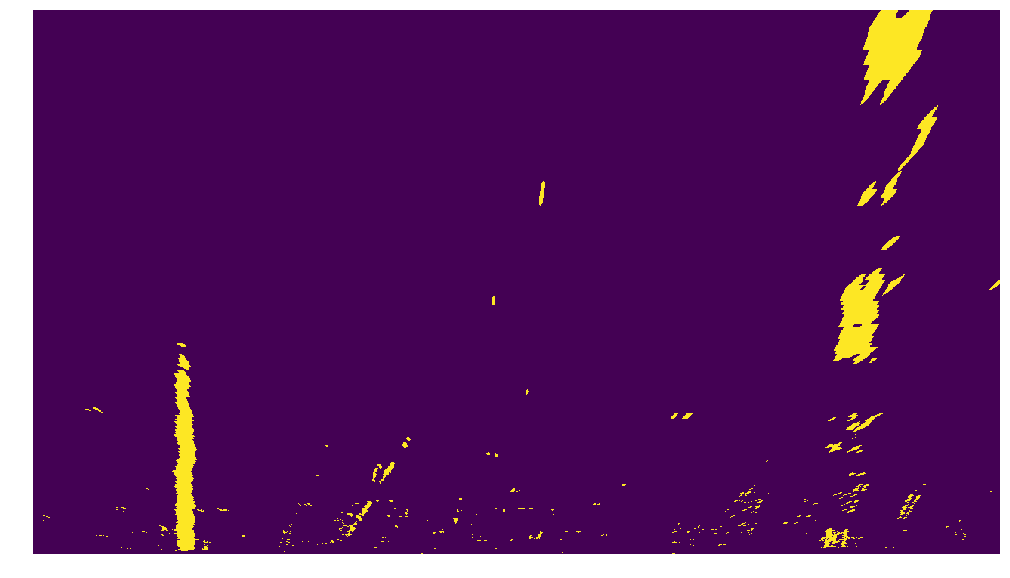

In [82]:
binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(20,10))
plt.imshow(binary_warped)
plt.axis("off")

# save as file
binary = 255 * binary_warped.astype("uint8")
cv2.imwrite("output_images/binary_warped.jpg", binary);

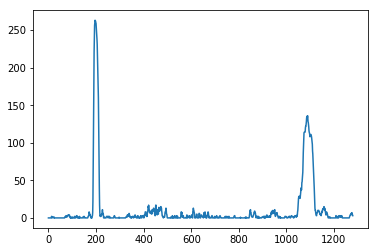

In [83]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram);

In [84]:
def measure_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    
# code mostly from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/2f928913-21f6-4611-9055-01744acc344f    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation

In [85]:
def find_hotpixels_for_lanes(binary_warped, debug=False):

    # code mostly copied from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
    
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r, d = measure_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d

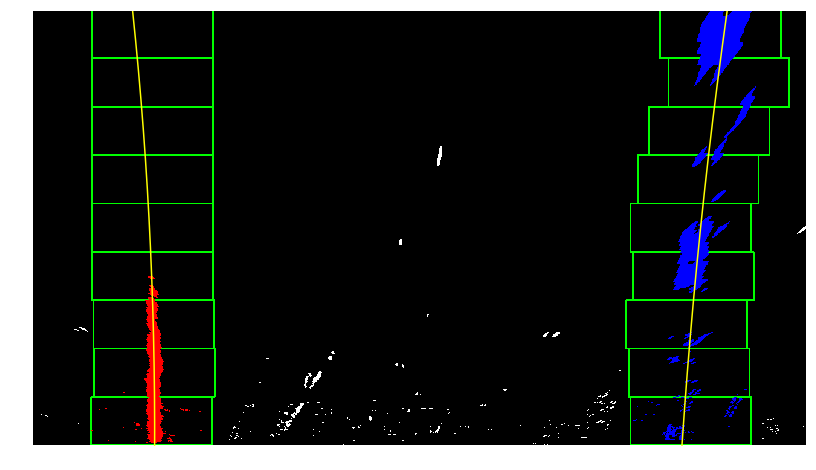

In [86]:
# Generate x and y values for plotting
left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img = find_hotpixels_for_lanes(binary_warped, debug=True)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

In [87]:
# Skip the sliding windows step once you know where the lines are
# code mostly from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



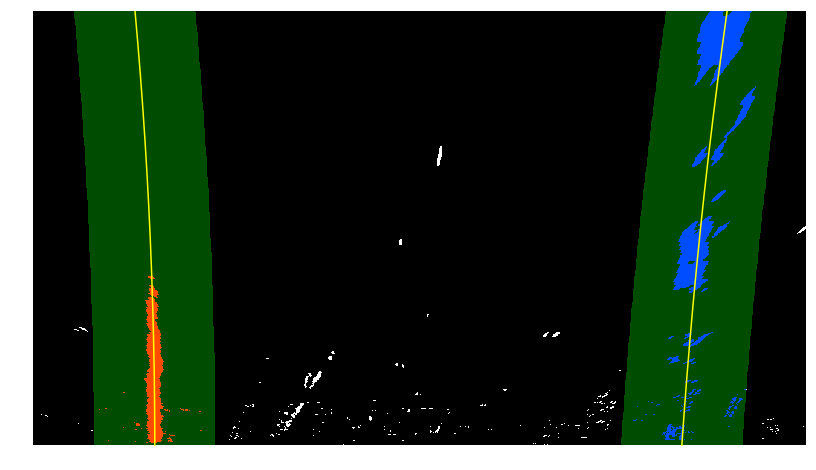

In [88]:
# Create an image to draw on and an image to show the selection window
# code from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

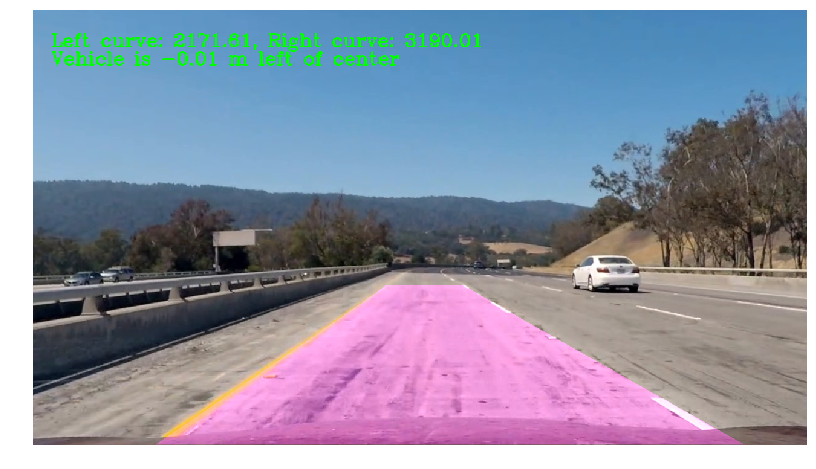

In [89]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):

    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 255))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Left curve: " + str(np.round(left_radius, 2)) + ", Right curve: " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Vehicle is {:.2f} m left of center".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result

result = draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");
save_image(result, "output_images/result.jpg")

In [90]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
# we have already calibrated camera. So assume we are using the same camera for rest of the images and video
dist_pickle = pickle.load( open( "camera_cal/adv_lane_pickle.p", "rb" ) )
saved_mtx = dist_pickle["mtx"]
saved_dist = dist_pickle["dist"]

In [91]:
def process_image(image):

    #undistorted, mtx, dist = undistort_lens(image, objpoints, imgpoints)
    undistorted = cv2.undistort(image, saved_mtx, saved_dist, None, mtx)
    
    _, combined_binary = thresholded_binary(undistorted)
    src, dst = get_src_dest_warp_points(image)
    binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_hotpixels_for_lanes(binary_warped)
    lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
    return lane_lines_img

In [53]:
# for debug purposes only
def extract_frames(image):
    
    global globalcount
    
    save_image(image, "~/tmp/frames/orig" + str(globalcount)+ ".jpg")
    
    #undistorted, mtx, dist = undistort_lens(image, objpoints, imgpoints)
    undistorted = cv2.undistort(image, saved_mtx, saved_dist, None, mtx)
    
    _, combined_binary = thresholded_binary(undistorted)
    src, dst = get_src_dest_warp_points(image)
    binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_hotpixels_for_lanes(binary_warped)
    lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
    
    save_image(lane_lines_img, "~/tmp/frames/lane" + str(globalcount)+ ".jpg")
    globalcount = globalcount + 1
    return lane_lines_img

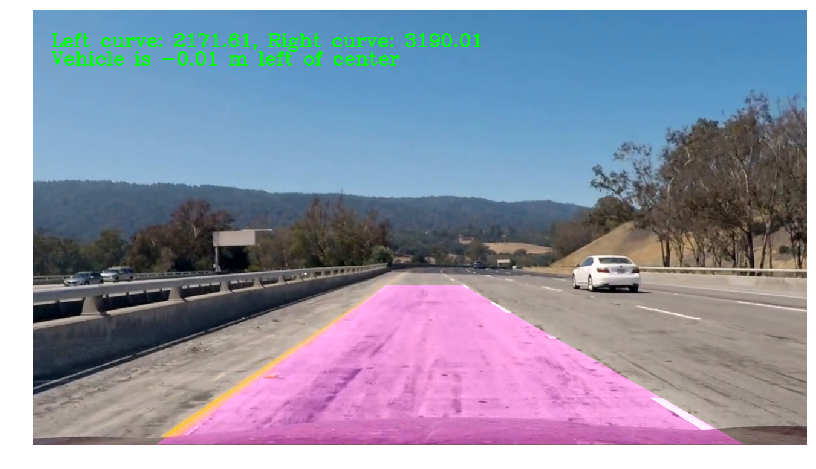

In [92]:
# Run on a test image
img = cv2.imread("test_images/orig3087.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

In [93]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) 
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:29<00:00,  6.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 3min 47s, sys: 1min 11s, total: 4min 59s
Wall time: 3min 30s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [94]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4
[MoviePy] Writing video output_images/project_video_challenge_output.mp4


100%|██████████| 485/485 [01:08<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 

CPU times: user 1min 21s, sys: 21.5 s, total: 1min 43s
Wall time: 1min 8s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))